In [1]:
using DrWatson
@quickactivate "WiFi-Imager"
includet(srcdir("funcs.jl"))

In [2]:
using CairoMakie

In [3]:
doi_size = 1.0
grid_number = 50
tx_xs = [0.6,  0.0, -0.6,  0.0]
tx_ys = [0.0, -0.6,  0.0,  0.6]
all_esp_num = 44
cen_freq = 2.462e9
air_permittivity = 1.0 + 0.0im
dis_ant = 0.085
Ni = length(tx_xs)
tx_pp = [0]
tx_scale = Ni ÷ 4
Ns = all_esp_num - Ni
L = 1
rx_xs = vcat(repeat(tx_xs[(1 * tx_scale):(1 * tx_scale)], div(Ns, 4)),
    [x for x in div(all_esp_num - 4, 8):-1:div(-(all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_xs[(3 * tx_scale):(3 * tx_scale)], div(Ns, 4)),
    [x for x in div(-(all_esp_num - 4), 8):1:div((all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant)
rx_ys = vcat(
    [x
     for x in div((all_esp_num - 4), 8):-1:div(-(all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_ys[(2 * tx_scale):(2 * tx_scale)], div(Ns, 4)),
    [x for x in div(-(all_esp_num - 4), 8):1:div((all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_xs[(4 * tx_scale):(4 * tx_scale)], div(Ns, 4)))
Rx_pos = [rx_xs'; rx_ys']
Tx_pos = [tx_xs'; tx_ys']
size(Rx_pos)

(2, 40)

In [4]:
parameters_all = map(
        frequency -> ConstantParameter(freq = frequency,
            doi_size_x = doi_size,
            doi_size_y = doi_size,
            grid_number_x = grid_number,
            grid_number_y = grid_number,
            txs_pos = Tx_pos,
            rxs_pos = Rx_pos),
        [cen_freq])
Ei_in_rxs_all, Ei_in_domain_all, GS_all, GDZ_all, V⁺_all, V⁻_all, GDV_neg_all, GSV_neg_all = get_shared_variables(
            parameters_all,
            L)

(Array{ComplexF64}[[-2.3489381044405007 - 0.1371931537587095im 0.026917181003784953 + 0.8415349620219135im -0.7557314854894388 - 0.21427975785921158im 1.0700792483809463 - 1.1895084708334234im; 0.7773787018254124 + 2.836582694914799im 0.4834629398673158 - 0.7552355031522417im 0.029643777577305293 - 0.801224077575005im -1.0528984015735203 - 1.1090713203257783im; … ; 2.5345008625099754 - 2.8929577919873326im -0.7435987092603003 + 1.2448566955900173im -0.19513839593076124 + 1.0457795286961769im -0.7435987092603003 + 1.2448566955900173im; -5.277292122336096 - 2.1916316022587385im 1.3191669626071554 - 0.3309222075122362im -0.851314221761285 - 0.47652753542656906im 1.3191669626071554 - 0.3309222075122362im]], Array{ComplexF64}[[0.3355521278864609 + 0.7665421167836604im 0.3355521278864609 + 0.7665421167836604im 1.4102119056893734 - 1.4058482986946033im 1.4102119056893734 - 1.4058482986946033im; -0.0028130872725863607 + 0.8424460187388251im -0.42757430574863486 + 0.734303665872228im 2.02074768

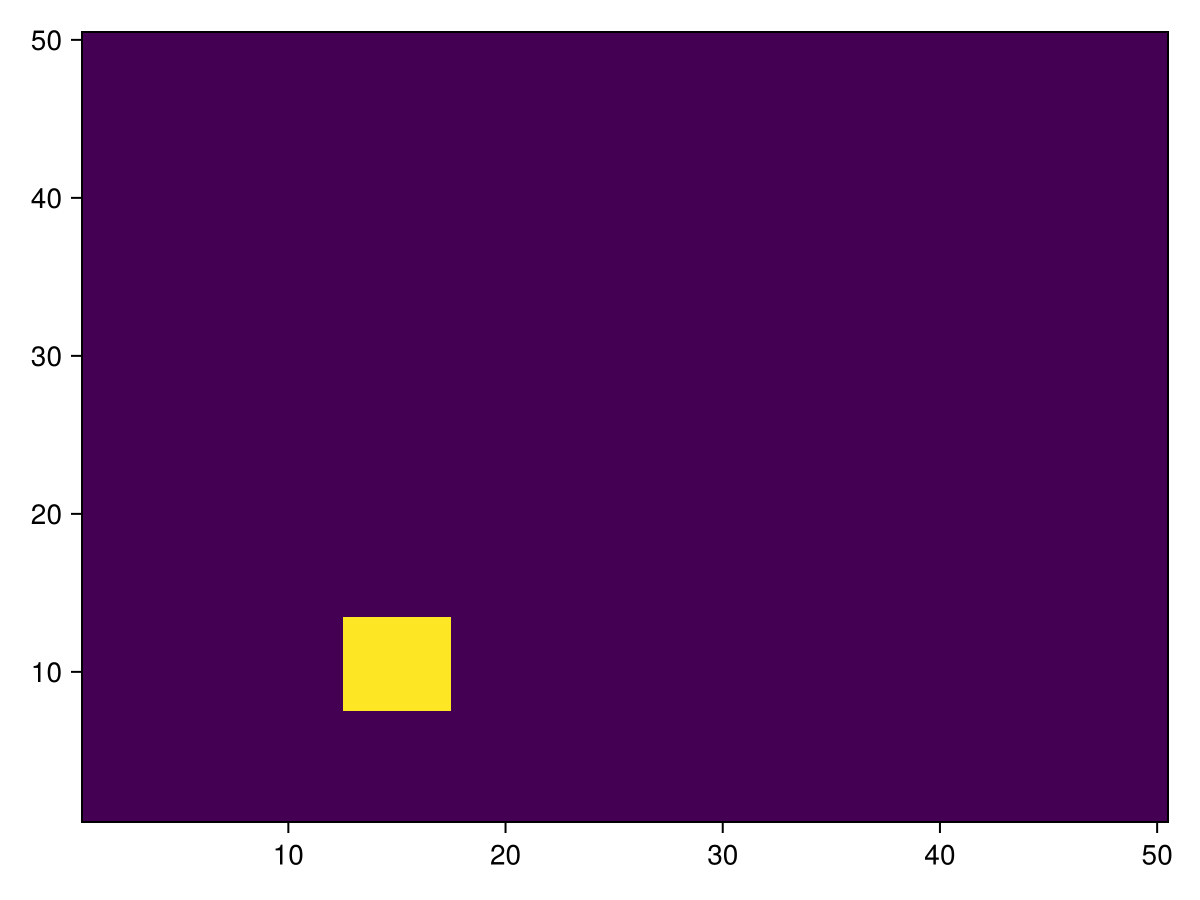

In [5]:
regeangle_pos = [[-35,25,-35,15,-25,15,-25,25],]./100
scatterer = get_scatterer(regeangle_pos,[1.6],parameters_all[1])
heatmap(abs.(scatterer))

In [6]:
frequency = cen_freq
sub_freq_ids = 1
parameters = parameters_all[sub_freq_ids]
Ei_in_rxs = Ei_in_rxs_all[sub_freq_ids]
Ei_in_domain = Ei_in_domain_all[sub_freq_ids]
GS = GS_all[sub_freq_ids]
GDZ = GDZ_all[sub_freq_ids]
V⁺, V⁻ = (V⁺_all[sub_freq_ids]), (V⁻_all[sub_freq_ids])
scatter_centroid_xs, scatter_centroid_ys, object_grid_indices = find_grids_with_object(
    parameters,
    scatterer)
impedance_in_domain = get_impedance_in_domain(parameters,
    vec(scatterer)[object_grid_indices],
    scatter_centroid_xs,
    scatter_centroid_ys)
current = get_induced_current(parameters,
    impedance_in_domain,
    Ei_in_domain[object_grid_indices, :],
    object_grid_indices;)
Es = get_scattered_field(parameters, current, GS;);

In [7]:
using Optimization
using OptimizationOptimJL
using Zygote
using LinearAlgebra

In [8]:
CSI = Es + (Ei_in_rxs)
F = ComplexF32.(abs2.(CSI))
α⁺ = get_α⁺(real.(F), Ei_in_rxs, GS, V⁺;)
J⁺ = (V⁺ * α⁺)
Ei_domain_add_GDJ_pos = Ei_in_domain_all[sub_freq_ids] .+ GD(J⁺, GDZ)
Ei_rx_add_GS_J_pos = Ei_in_rxs .+ GS * J⁺;

In [33]:
ξ_gt = vec(scatterer .- 1) .* (-1im * parameters.k₀ / parameters.η)
F_norm_sq = sum(abs2, F, dims=1)
J_po_norm_sq = sum(abs2, J⁺, dims=1) .+ 1e-7
Es_norm_sq = sum(abs2, Es, dims=1);
unique(ξ_gt)

2-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 - 0.0821785899068694im

In [34]:
image_scatter = zeros(ComplexF64,size(scatterer))
image_scatter[scatterer .== 1] .= 1.0
image_scatter[ scatterer .!= 1] .= 0.0
size(image_scatter)


(50, 50)

In [35]:
rosenbrock = (ξ_value, F) -> begin
    ξ = (ξ_value[1]+ ξ_value[2] * 1im) .* vec(image_scatter)
    delta_dat, delta_sta = get_delta_dat_and_sta_phaseless(
        ξ,
        GS,
        GDZ,
        V⁻,
        F,
        Ei_in_domain,
        J⁺,
        Ei_in_rxs)
    return real(sum(sum(conj(delta_dat) .* delta_dat, dims=1) ./ F_norm_sq) +
                sum(sum(conj(delta_sta) .* delta_sta, dims=1) ./ J_po_norm_sq))
end

rosenbrock([0.0,-0.821], F)

10.741459989077402

In [36]:
using OptimizationOptimisers
optf = Optimization.OptimizationFunction(rosenbrock)
prob = Optimization.OptimizationProblem(optf, [0.0, -0.05], F)
# ξ_hat = Optimization.solve(prob, LBFGS();maxiters=1000).u;

sol = Optimization.solve(prob,NelderMead();)

retcode: Success
u: 2-element Vector{Float64}:
 -0.0012176513671874997
 -0.05

In [37]:
ξ_hat = sol.u
rosenbrock(ξ_hat, F)

13.471911893573203

In [38]:
γ = sum(Es .* conj(GS*GS'*Es), dims=1) ./ sum(abs2.(GS*GS'*Es),dims=1)


1×4 Matrix{ComplexF64}:
 0.00154724-2.77547e-20im  …  0.00195423-6.36263e-20im

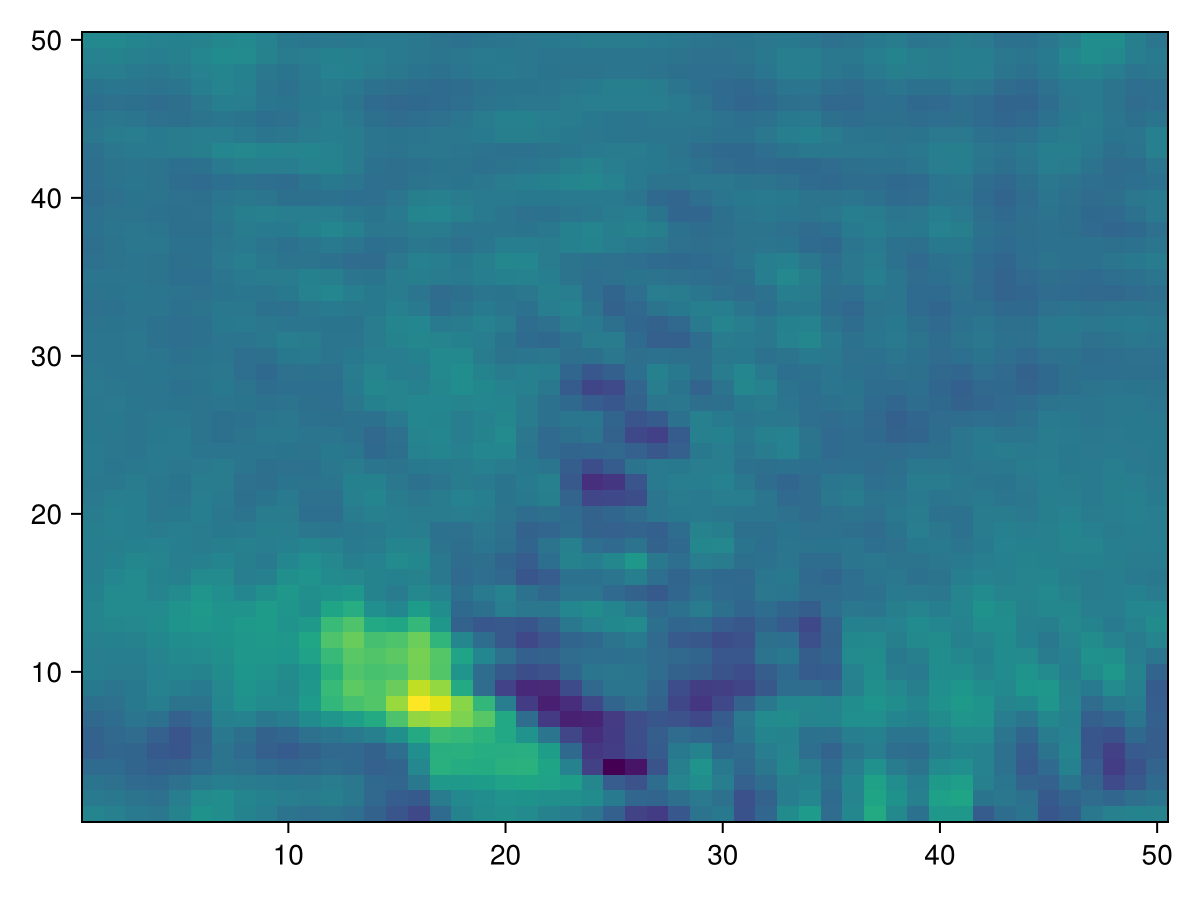

In [39]:
J_bp = repeat(γ, length(scatterer),1) .* (GS'*Es)
Et = Ei_in_domain .+ GD(J_bp, GDZ)
num = sum(J_bp .* conj(Et),dims=2)
den = sum(abs2.(Et),dims=2)
ξ_bp = reshape(num ./ den, grid_number, grid_number)
heatmap(real.(ξ_bp ./ (-1im * parameters.k₀ / parameters.η)) .+ 1.0)